In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

def eval (out, model, label):
    probs = model.activate(out)
    unc = model.aleatoric(out).cpu()
    pmax = probs.argmax(dim=1)
    lmax = label.argmax(dim=1)
    mis = pmax.cpu() != lmax.cpu()

    agree = mis.bool() == (unc > .5)

    return agree.float().mean().item()


In [18]:
from models.evidential import *

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [46]:
from datasets.carla import compile_data as compile_data_carla
from datasets.nuscenes import compile_data as compile_data_nuscenes
from tools.utils import *

In [52]:
evidential = Evidential([7], backbone="lss", n_classes=2)
evidential.load(torch.load("../outputs_bin/carla/aug/lss_ufocal_gamma=.1_ol=.01_k=64/19.pt"))

Loaded pretrained weights for efficientnet-b0
BETA LAMBDA: 0.001


In [48]:
loader_c = compile_data_carla("ood", "mini", "../../data/carla", "vehicle")
loader_n = compile_data_nuscenes("ood", "mini", "../../data/nuscenes", "vehicle")

In [ ]:
images, intrinsics, extrinsics, labels, oods = loader_c.dataset[268]
images = images[None].to(7)
intrinsics = intrinsics[None].to(7)
extrinsics = extrinsics[None].to(7)

In [90]:
alpha = evidential(images, intrinsics, extrinsics)
preds = evidential.activate(alpha)
ep = evidential.epistemic(alpha)

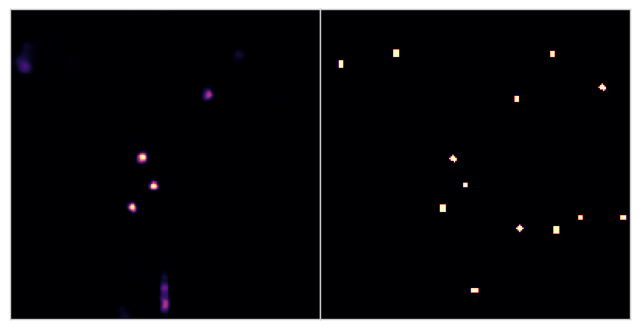

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(8, 16))
fig.subplots_adjust(wspace=0, hspace=0)

axs[0].imshow(ep[0, 0].detach().cpu(), cmap="magma")
axs[1].imshow(oods[0], cmap="magma")

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])